Проведите анализ с помощью SSA в любом из временных рядов с первого занятия.
Посмотрите на результаты с разными длинами окон.
Обязательно визуализируйте результаты аналогично материалу с занятия.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from cycler import cycler

In [39]:
data = pd.read_csv('daily-total-female-births-in-cal.csv', index_col='Date', parse_dates=True)
data.head()

,Count
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


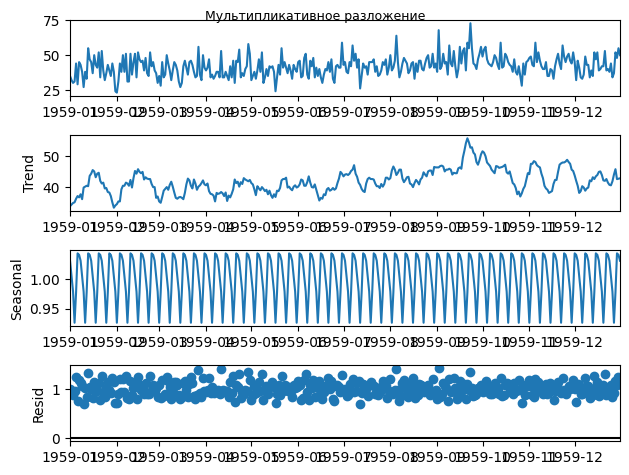

In [3]:
decompose = seasonal_decompose(data, model='multiplicative', extrapolate_trend='freq')
decompose.plot().suptitle('Мультипликативное разложение', fontsize=9)
plt.show()

In [ ]:
print(adfuller(data, 0)[1])

5.187572355823107e-28


In [4]:
N = len(data)
L = 50
K = N - L + 1 
traj_matrix = np.column_stack([data[i:i+L] for i in range(0, K)])

# создана матрица траектории (Ганкелева матрица) на основе временного ряда

In [5]:
traj_matrix

array([[35, 32, 30, ..., 40, 40, 45],
       [32, 30, 31, ..., 40, 45, 35],
       [30, 31, 44, ..., 45, 35, 35],
       ...,
       [45, 46, 39, ..., 37, 52, 48],
       [46, 39, 48, ..., 52, 48, 55],
       [39, 48, 37, ..., 48, 55, 50]])

Text(0.5, 1.0, 'Траекторная матрица для временного ряда')

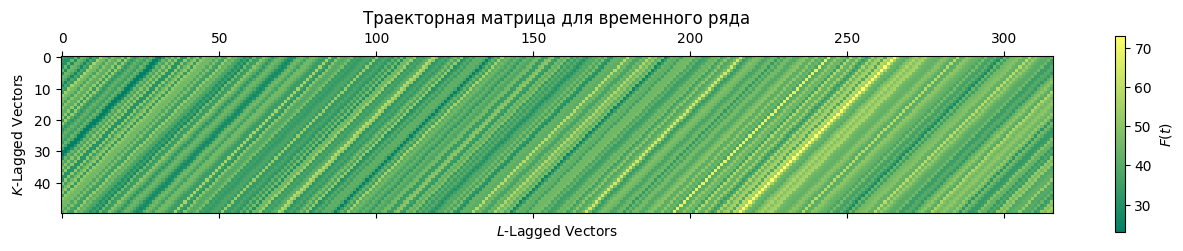

In [6]:
ax = plt.matshow(traj_matrix, cmap='summer')
plt.xlabel("$L$-Lagged Vectors")
plt.ylabel("$K$-Lagged Vectors")
plt.colorbar(ax.colorbar)
ax.colorbar.set_label("$F(t)$")
plt.title("Траекторная матрица для временного ряда")

In [7]:
U, Sigma, V = np.linalg.svd(traj_matrix)
V = V.T 

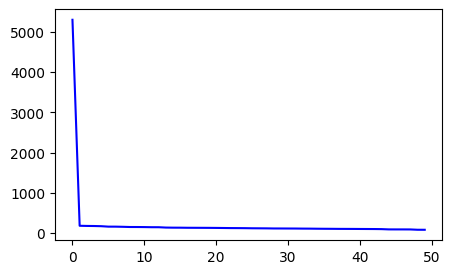

In [8]:
plt.figure(figsize=(5, 3))
plt.plot(Sigma, 'b') 

# самое большое сингулярное значение и как быстро значения убывают

In [9]:
d = np.linalg.matrix_rank(traj_matrix)
X_elem = np.array([Sigma[i] * np.outer(U[:, i], V[:, i]) for i in range(0, d)])

In [10]:
np.allclose(traj_matrix, X_elem.sum(axis=0))

True

In [11]:
def plot_2d(m, title=''):
    plt.imshow(m) 
    plt.xticks([]) 
    plt.yticks([])
    plt.title(title)

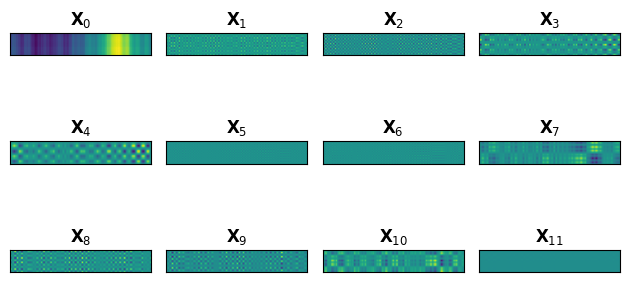

In [12]:
n = min(12, d) 
for i in range(n):
    plt.subplot(4,4,i+1)
    title = "$\mathbf{X}_{" + str(i) + "}$"
    plot_2d(X_elem[i], title)
plt.tight_layout()

# мне кажется по графику Х0, тренд не ярко выражен, если он, вообще, есть
# Х4 - это, наверное, сезонность, а Х7 - тренд и периодичность
# что такое Х10 мне сложно определить, может это периодисчность, но остальные, скорее всего, это шум 

Text(0, 0.5, 'Вклад (%)')

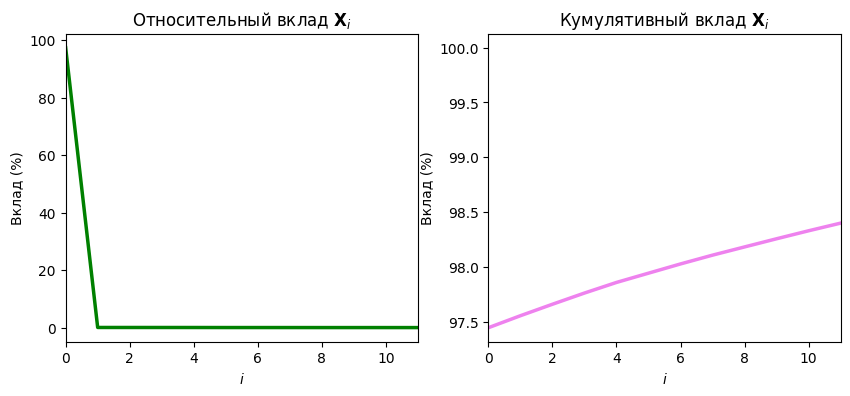

In [13]:
sigma_sumsq = (Sigma**2).sum()
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(Sigma**2 / sigma_sumsq * 100, lw=2.5, color='green')
ax[0].set_xlim(0,11)
ax[0].set_title("Относительный вклад $\mathbf{X}_i$")
ax[0].set_xlabel("$i$")
ax[0].set_ylabel("Вклад (%)")

ax[1].plot((Sigma**2).cumsum() / sigma_sumsq * 100, lw=2.5, color='violet')
ax[1].set_xlim(0,11)
ax[1].set_title("Кумулятивный вклад $\mathbf{X}_i$")
ax[1].set_xlabel("$i$")
ax[1].set_ylabel("Вклад (%)")


# матрица Х0 это вклад в районе 97%, Х1 около 0 значения
# не уверена, но, возможно, что группировать надо матрицы Х0 и Х1

In [14]:
def X_to_TS(X_i):
    X_rev = X_i[::-1]
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

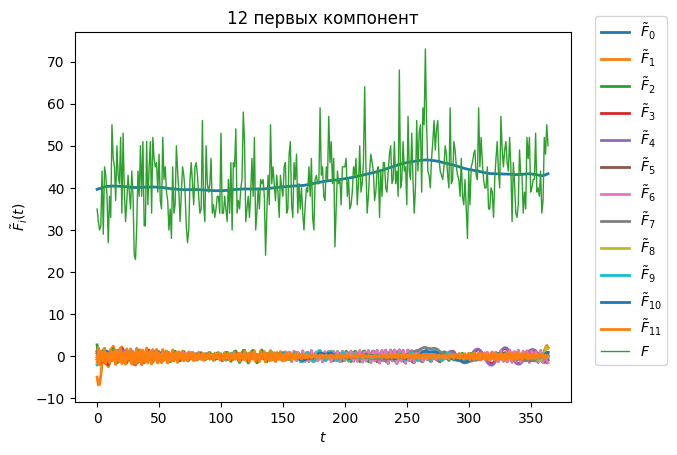

In [15]:
n = min(12, d) 
t = np.arange(0, N)

fig = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab10').colors)
fig.axes.set_prop_cycle(color_cycle)

for i in range(n):
    F_i = X_to_TS(X_elem[i])
    fig.axes.plot(t, F_i, lw=2)

fig.axes.plot(t, data, alpha=1, lw=1)
fig.set_xlabel("$t$")
fig.set_ylabel(r"$\tilde{F}_i(t)$")
legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
fig.set_title("12 первых компонент")
fig.legend(legend, loc=(1.05,0.1))

# сложно что-то понять. F1 тренд, а F11 - шум.
# проглядывается F4, это похоже на периодичность

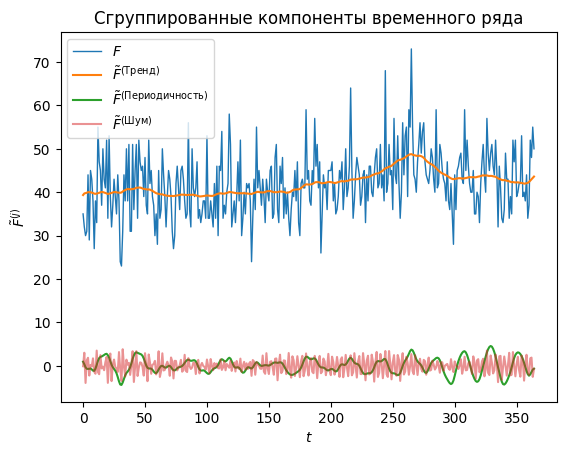

In [16]:
F_trend = X_to_TS(X_elem[[0, 7]].sum(axis=0))
F_periodic = X_to_TS(X_elem[[3,4, 10]].sum(axis=0))
F_noise = X_to_TS(X_elem[[5, 6, 11]].sum(axis=0))

plt.plot(t, data, lw=1)
plt.plot(t, F_trend)
plt.plot(t, F_periodic)
plt.plot(t, F_noise, alpha=0.5)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}^{(j)}$")
groups = ['Тренд', 'Периодичность', 'Шум']
legend = ["$F$"] + [r"$\tilde{F}^{(\mathrm{%s})}$"%group for group in groups]
plt.legend(legend)
plt.title("Cгруппированные компоненты временного ряда")
plt.show()

In [17]:
w = np.array(list(np.arange(L)+1) + [L]*(K-L-1) + list(np.arange(L)+1)[::-1])

F_elem = np.array([X_to_TS(X_elem[i]) for i in range(d)])

F_wnorms = np.array([w.dot(F_elem[i]**2) for i in range(d)])
F_wnorms = F_wnorms**-0.5

Wcorr = np.identity(d)
for i in range(d):
    for j in range(i+1, d):
        Wcorr[i,j] = abs(w.dot(F_elem[i]*F_elem[j]) * F_wnorms[i] * F_wnorms[j])
        Wcorr[j,i] = Wcorr[i,j]

Text(0.5, 1.0, 'Корреляционная матрица')

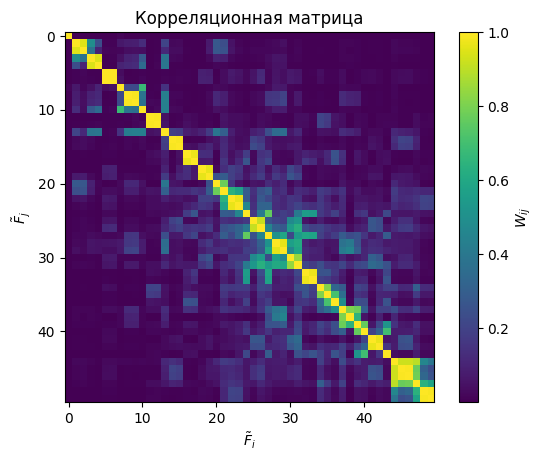

In [18]:
ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.title('Корреляционная матрица')

In [21]:
class SSA(object):
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        if not isinstance(tseries, self.__supported_types):
          raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        if not save_mem:
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
        self.V = "Re-run with save_mem=False to retain the V matrix."

    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)

    def reconstruct(self, indices):
        if isinstance(indices, int): indices = [indices]
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    def plot_wcorr(self, min=None, max=None):
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)

In [43]:
data = data.flatten()

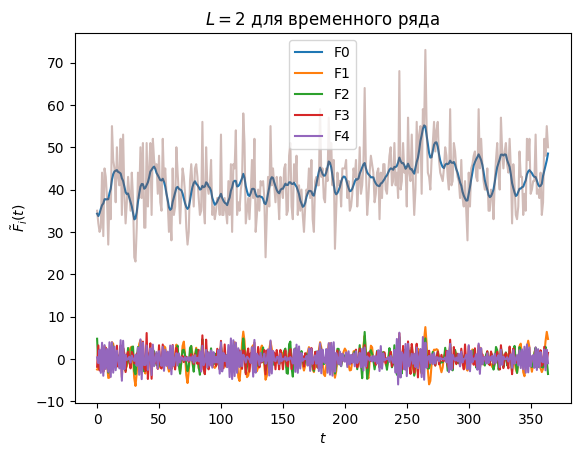

In [53]:
F_ssa_L2 = SSA(data, 5)
F_ssa_L2.components_to_df().plot()
F_ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=2$ для временного ряда");

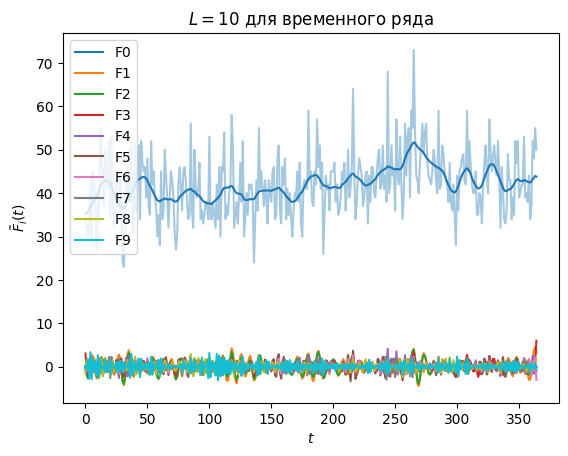

In [47]:
F_ssa_L2 = SSA(data, 10)
F_ssa_L2.components_to_df().plot()
F_ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=10$ для временного ряда");

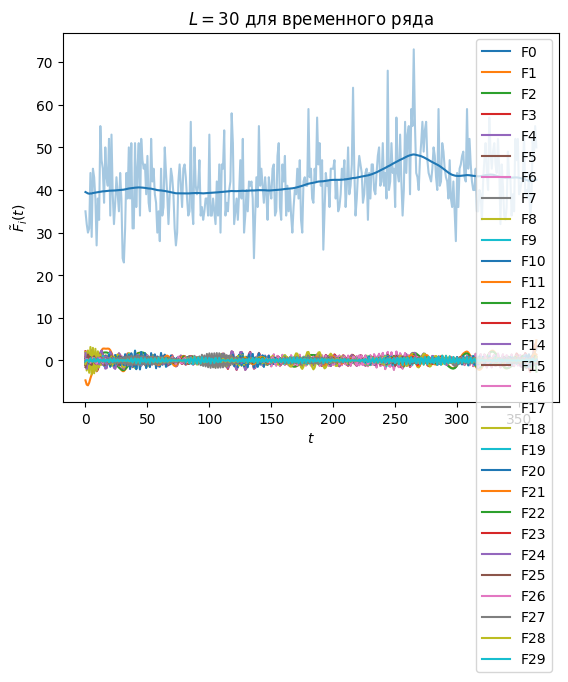

In [51]:
F_ssa_L2 = SSA(data, 30)
F_ssa_L2.components_to_df().plot()
F_ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=30$ для временного ряда");

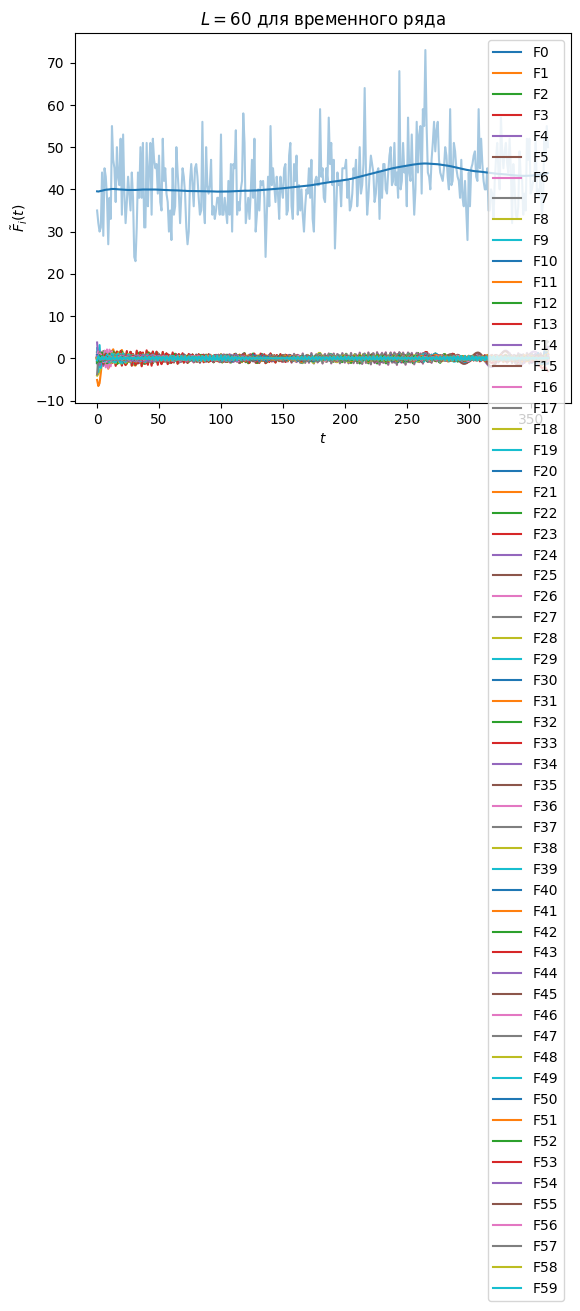

In [52]:
F_ssa_L2 = SSA(data, 60)
F_ssa_L2.components_to_df().plot()
F_ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=60$ для временного ряда");